In [97]:
import numpy as np
import random
import torch
import math
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

The following is the code for the game enviornment and implementation of the logic bot

In [2]:

class Game:
    def __init__(self, width, height, num_of_mines):
        self.width = width
        self.height = height
        self.num_of_mines = num_of_mines
        self.grid = torch.Tensor([[0 for _ in range(self.height)] for _ in range(self.width)])
        self.mines = set()
        self.clue_number = {}
        self.GenerateBoard()
        self.opened = set()
        self.marked = set()
        self.encoding = {
            0 : [1,0,0,0,0,0,0,0,0,0,0],
            1 : [0,1,0,0,0,0,0,0,0,0,0],
            2 : [0,0,1,0,0,0,0,0,0,0,0],
            3 : [0,0,0,1,0,0,0,0,0,0,0],
            4 : [0,0,0,0,1,0,0,0,0,0,0],
            5 : [0,0,0,0,0,1,0,0,0,0,0],
            6 : [0,0,0,0,0,0,1,0,0,0,0],
            7 : [0,0,0,0,0,0,0,1,0,0,0],
            8 : [0,0,0,0,0,0,0,0,1,0,0],
        }

    def GenerateBoard(self):
        while len(self.mines) < self.num_of_mines:
            x = random.randint(0, self.width - 1)
            y = random.randint(0, self.height - 1)
            self.mines.add((x, y))

        for mine in self.mines:
            x, y = mine
            self.grid[x][y] = 1

        for i in range(self.width):
            for j in range(self.height):
                self.clue_number[(i, j)] = 0

        for i in range(self.width):
            for j in range(self.height):
                if self.grid[i][j] == 1:
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:
                            if 0 <= i + dx < self.width and 0 <= j + dy < self.height:
                                self.clue_number[(i + dx, j + dy)] += 1

    def GetNeighbors(self, cell):
        x, y = cell
        neighbors = set()
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0: continue
                if 0 <= x + dx < self.width and 0 <= y + dy < self.height: neighbors.add((x + dx, y + dy))
        return neighbors

    def Open(self, cell):
        self.opened.add(cell)
        return False if cell in self.mines else True

    def GetMines(self): return self.mines

    def GetGrid(self):
        res = [[0 for _ in range(self.height)] for _ in range(self.width)]
        for clue in self.clue_number:
            res[clue[0]][clue[1]] = self.clue_number[clue]
        return res

    def Mark(self,cells):
        self.marked.update(cells)
    
    def Free(self):
        free_cells = []
        for i in range(self.width):
            for j in range(self.height):
                if self.clue_number[(i,j)] == 0: free_cells.append((i,j))
        return random.sample(free_cells,1)[0]
    
    def GetGame(self):
        encoding  = [[[] for _ in range(self.height)] for _ in range(self.width)]
        for i in range(self.width):
            for j in range(self.height):
                if (i, j) in self.opened: encoding[i][j] = self.encoding[self.clue_number[(i,j)]]
                elif (i,j) in self.marked: encoding[i][j] = [0,0,0,0,0,0,0,0,0,1,0]
                else: encoding[i][j] = [0,0,0,0,0,0,0,0,0,0,1]

        res = [[] for _ in range(11)]
        for k in range(11):
            temp = [[0 for _ in range(self.height)] for _ in range(self.width)]
            for i in range(self.width):
                for j in range(self.height): temp[i][j] = encoding[i][j][k]
            res[k] = temp

        return res

The following code represents the following psuedo code:<br>
• Initialize the game environment. The bot gets information by querying the environment.<br>
• Initialize the following sets: cells remaining (initially all cells), inferred safe (initially empty), inferred mine
(initially empty)<br>
• Initialize a hashmap, clue number, to store for each opened cell what its clue number was.<br>
• Loop until end of game:<br>
– If inferred safe is not empty, pick a cell from it to open, otherwise, select a cell from cells remaining at
random.<br>
– Open the selected cell. If it is a mine, the game ends. If it is not, update the cell sets appropriately, and
save the clue number.<br>
– For each cell with a revealed clue:<br>
∗ If (cell clue) - (# neighbors inferred to be mines) = (# unrevealed neighbors), mark each unrevealed
neighbor as a mine, and remove them from cells remaining.<br>
∗ If ((# neighbors) - (cell clue)) - (# neighbors revealed or inferred to be safe) = (# unrevealed
neighbors), mark each unrevealed neighbor as safe, and remove them from cells remaining.<br>
– If any cells were inferred as safe or mine during the above for loop, repeat the loop, until no new inferences
are found.<br>
• Return the number of cells successfully opened or revealed as safe, and the number of mines triggered.

In [87]:
class LogicBot:
    def __init__(self, game):
        self.game_environment = game
        self.cells_remaining = {(x, y) for x in range(game.width) for y in range(game.height)}
        self.inferred_safe = set()
        self.inferred_mine = set()
        self.clue_number = {}
        self.opened = set()

    def play(self):
        steps = []
        cells_opened = 0
        mines_triggered = 0
        win = True
        while self.cells_remaining or self.inferred_safe:
            selected_cell = self.select_cell()
            self.opened.add(selected_cell)
            step = [[0 for i in range(self.game_environment.height)] for j in range(self.game_environment.width)]
            step[selected_cell[0]][selected_cell[1]] = 1
            steps.append([self.game_environment.GetGame(),step])
            if not self.game_environment.Open(selected_cell):
                #print('BANG')
                mines_triggered += 1
                win = False
                break
            else:
                cells_opened += 1
                cur_mines = -1
                cur_safe = -1
                while cur_mines != len(self.inferred_mine) and cur_safe != len(self.inferred_safe):
                    cur_mines = len(self.inferred_mine)
                    cur_safe = len(self.inferred_safe)
                    for cell in self.opened: self.update_inferences(cell)
            #print()
            #self.print_state()
            #print('cells opened =',cells_opened)
            #print('selected cell =',selected_cell)
            #print('cells remaining =',len(self.cells_remaining))
            #print('cells inferred safe =',len(self.inferred_safe))
        return win, steps
        #return cells_opened, mines_triggered

    def select_cell(self):
        cell = (-1,-1)
        if self.inferred_safe:
            cell = random.sample(list(self.inferred_safe),1)[0]
            self.inferred_safe.remove(cell)
        else:
            if self.opened: cell = random.sample(list(self.cells_remaining),1)[0]
            else: cell = self.game_environment.Free()
            
            self.cells_remaining.remove(cell)
        return cell

    def update_inferences(self, selected_cell):
        clue = self.game_environment.GetGrid()[selected_cell[0]][selected_cell[1]]
        neighboring_cells = self.game_environment.GetNeighbors(selected_cell)

        mine_neighbors = sum(1 for neighbor in neighboring_cells if neighbor in self.inferred_mine)
        safe_neighbors = sum(1 for neighbor in neighboring_cells if neighbor in self.inferred_safe)
        unrevealed_neighbors = neighboring_cells-self.opened

        if clue - mine_neighbors == len(unrevealed_neighbors):
            self.inferred_mine.update(unrevealed_neighbors)
            self.game_environment.Mark(unrevealed_neighbors)
            self.cells_remaining -= unrevealed_neighbors
        if len(neighboring_cells)-clue-(safe_neighbors+(len(neighboring_cells)-len(unrevealed_neighbors))) == len(unrevealed_neighbors):
            self.inferred_safe.update(unrevealed_neighbors)
            self.cells_remaining -= unrevealed_neighbors

    def print_state(self):
        for i in range(self.game_environment.width):
            s = ''
            for j in range(self.game_environment.height):
                if (i, j) in self.opened: s += 'X '
                elif (i, j) in self.inferred_mine: s += 'M '
                elif (i, j) in self.inferred_safe: s += 'S '
                else: s += 'O '
            print(s)


Using pickles, library and a custom Dataset object, datasets are easily accessible and can be saved and loaded at any time. This way updating preexisting dataset is possible.

In [4]:
import pickle
def save_object(obj,filename):
    try:
        with open(filename+".pickle", "wb") as f: pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex: print("Error during pickling object (Possibly unsupported):", ex)
def load_object(filename):
    try:
        with open(filename+".pickle", "rb") as f:  return pickle.load(f)
    except Exception as ex: print("Error during unpickling object (Possibly unsupported):", ex)


In [5]:
class Dataset:
    def __init__(self): self.data = []
    def Add(self,data):
        if data:
            for x in data: self.data.append(x)
    def Shuffle(self): random.shuffle(self.data)

Task 1<br>
In this task, the logic bot and network bot performance is compared on the following boards<br>
- Easy: 9x9 board with 10 mines<br>
- Intermediate: 16x16 board with 40 mines<br>
- Expert: 9x9 board with 99 mines<br>

In [6]:
dataset_easy = Dataset()
dataset_medium = Dataset()
dataset_hard = Dataset()

The following corresponds with how data is collected:<br>
The input is represented as an AxB matrix with 11 features, where A is the width and B is the height of the board. Each feature corresponds to the state of each cell. This is done using one hot encoding. The corresponding states are represented as follows:<br>
0 : 		(1,0,0,0,0,0,0,0,0,0,0)<br>
1 : 		(0,1,0,0,0,0,0,0,0,0,0)<br>
2 : 		(0,0,1,0,0,0,0,0,0,0,0)<br>
3 : 		(0,0,0,1,0,0,0,0,0,0,0)<br>
4 : 		(0,0,0,0,1,0,0,0,0,0,0)<br>
5 : 		(0,0,0,0,0,1,0,0,0,0,0)<br>
6 : 		(0,0,0,0,0,0,1,0,0,0,0)<br>
7 : 		(0,0,0,0,0,0,0,1,0,0,0)<br>
8 : 		(0,0,0,0,0,0,0,0,1,0,0)<br>
unrevealed : 	(0,0,0,0,0,0,0,0,0,1,0)<br>
mine : 		(0,0,0,0,0,0,0,0,0,0,1)<br>
This allows for the model to learn the difference between one state and the other.<br>
Initially approach for the output is an AxB matrix with 1 feature that corresponds with the probability of being safe. This will be calculated using a softmax layer to determine the ‘safest’ cell to choose. The cell with the highest probability will be chosen as it is the highest probability of being a safe cell. The cells that are already opened will be stored and will be set to 0 to prevent the model from opening the same cell twice. <br>
However, this approach makes the network bot copy the logic bot. In order for the network bot to out perform the logic bot, the approach for data collection goes as follows:<br>
The output is an AxB matrix with 1 feature that corresponds with the probabilty of a cell being a mine. The output passed always shows the exact location of the mines regardless of the cells covered. Allowing the network bot to learn what board configurations correspond with certain mine configurations.


In [7]:
win = False
win_count = 0
count = 0
while count < 10000:
    count+=1
    game = Game(9,9,10)
    bot = LogicBot(game)
    win, steps = bot.play()
    if win:
        dataset_easy.Add(steps[1:])
        win_count+=1
    else: dataset_easy.Add(steps[1:-1])
print('Winrate = {:.2f}%'.format((win_count/count)*100))


Winrate = 2.68%


In [35]:
win = False
win_count = 0
count = 0
while count < 1000:
    count+=1
    game = Game(16,16,40)
    bot = LogicBot(game)
    win, steps = bot.play()
    if win:
        dataset_medium.Add(steps[1:])
        win_count+=1
    else: dataset_medium.Add(steps[1:-1])
print('Winrate = {:.2f}%'.format((win_count/count)*100))


Winrate = 0.00%


In [19]:
win = False
win_count = 0
count = 0
while count < 1000:
    count+=1
    game = Game(16,30,99)
    bot = LogicBot(game)
    win, steps = bot.play()
    if win:
        dataset_hard.Add(steps[1:])
        win_count+=1
    else: dataset_hard.Add(steps[1:-1])
print('Winrate = {:.2f}%'.format((win_count/count)*100))


Winrate = 0.00%


In [23]:
print(len(dataset_easy.data))
print(len(dataset_medium.data))
print(len(dataset_hard.data))

485816
75561
53769


In [10]:
save_object(dataset_easy,'dataset_easy')
save_object(dataset_medium,'dataset_medium')
save_object(dataset_hard,'dataset_hard')

In [22]:
dataset_easy = load_object('dataset_easy')
dataset_medium = load_object('dataset_medium')
dataset_hard = load_object('dataset_hard')

The model uses a CNN with an increasing and then decreasing architecture where 2 convolutional layers are used to collect local features and then passed through 2 linear layers in order to find global features based on the previous local features calculated. Batch normalization and layer nomalization is intertwined between the layers and the model utilizes a ReLU activation function.

In [7]:
class MinesweeperModel(nn.Module):
    def __init__(self, width, height):
        super(MinesweeperModel, self).__init__()
        self.width = width
        self.height = height

        # Define input layer
        self.conv_layer1 = nn.Conv2d(11,30,3,1)
        self.batch_norm1 = nn.BatchNorm2d(30)
        self.conv_layer2 = nn.Conv2d(30,60,2,1)
        self.batch_norm2 = nn.BatchNorm2d(60)
        self.linear_layer1 = nn.Linear(int(60*(self.width-3)*(self.height-3)),500)
        self.layer_norm1 = nn.LayerNorm(500)
        self.linear_layer2 = nn.Linear(500,200)
        self.layer_norm2 = nn.LayerNorm(200)
        self.output_layer = nn.Linear(200, self.width * self.height)

    def forward(self, input):
        output = nn.ReLU()(self.conv_layer1(input))
        output = self.batch_norm1(output)
        output = nn.ReLU()(self.conv_layer2(output))
        output = self.batch_norm2(output)
        output = nn.Flatten()(output)
        output = nn.ReLU()(self.linear_layer1(output))
        output = self.layer_norm1(output)
        output = nn.ReLU()(self.linear_layer2(output))
        output = self.layer_norm2(output)
        output = self.output_layer(output)
        #output = nn.Softmax()(output)
        output = output.reshape(-1,self.width,self.height)
        return output


In [10]:

def get_batch(dataset, size):
    x = []
    y = []
    data = random.sample(dataset.data,size)
    for a in data:
        x.append(a[0])
        y.append(a[1])
    return x,y

Training for the three types of models corresponding to board difficulty is described as follows:<br>
The models are trained on 20 epochs with a batch size of 32. The model then uses binary cross entropy to determine the probability of the existence of a mine within a given cell. Adam optimizater is used with a learning rate of 0.01 and regularization factor of 0.0001.

In [29]:
model = MinesweeperModel(9,9)

In [30]:
model.train()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay = 0.0001)
batch_size = 1000
validation_input, validation_output = get_batch(dataset_easy,200)

validation_input = torch.Tensor(validation_input)
validation_output = torch.Tensor(validation_output)

for epoch in range(20):
    total_loss = 0
    total_validation_loss = 0
    for batch in range(len(dataset_easy.data)//batch_size):
        input, output = get_batch(dataset_easy,batch_size)
        input = torch.Tensor(input)
        output = torch.Tensor(output)
        logits = model(input)
        loss = loss_function(logits, output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss = loss.item()

        with torch.no_grad():
            validation_logits = model(validation_input)
            total_validation_loss += loss_function(validation_logits,validation_output).item()
    print('Average Training Loss over Batches = {:.4f}'.format(total_loss/ (len(dataset_easy.data)//batch_size)))
    print('Average Validation Loss over Batches = {:.4f}'.format(total_validation_loss/ (len(dataset_easy.data)//batch_size)))

Average Training Loss over Batches = 0.0002
Average Validation Loss over Batches = 0.1007
Average Training Loss over Batches = 0.0002
Average Validation Loss over Batches = 0.0869
Average Training Loss over Batches = 0.0002
Average Validation Loss over Batches = 0.0833
Average Training Loss over Batches = 0.0002
Average Validation Loss over Batches = 0.0805
Average Training Loss over Batches = 0.0002
Average Validation Loss over Batches = 0.0784
Average Training Loss over Batches = 0.0002
Average Validation Loss over Batches = 0.0795
Average Training Loss over Batches = 0.0002
Average Validation Loss over Batches = 0.0818
Average Training Loss over Batches = 0.0002
Average Validation Loss over Batches = 0.0806
Average Training Loss over Batches = 0.0002
Average Validation Loss over Batches = 0.0811
Average Training Loss over Batches = 0.0002
Average Validation Loss over Batches = 0.0801
Average Training Loss over Batches = 0.0002
Average Validation Loss over Batches = 0.0797
Average Tr

In [31]:
torch.save(model.state_dict(),'minesweeper_easy.pth')

In [42]:
model = MinesweeperModel(16,16)

In [43]:
model.train()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay = 0.0001)
batch_size = 32
validation_input, validation_output = get_batch(dataset_medium,200)

validation_input = torch.Tensor(validation_input)
validation_output = torch.Tensor(validation_output)

for epoch in range(20):
    total_loss = 0
    total_validation_loss = 0
    for batch in range(len(dataset_medium.data)//batch_size):
        input, output = get_batch(dataset_medium,batch_size)
        input = torch.Tensor(input)
        output = torch.Tensor(output)
        logits = model(input)
        loss = loss_function(logits, output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss = loss.item()

        with torch.no_grad():
            validation_logits = model(validation_input)
            total_validation_loss += loss_function(validation_logits,validation_output).item()
    print('Average Training Loss over Batches = {:.4f}'.format(total_loss/ (len(dataset_medium.data)//batch_size)))
    print('Average Validation Loss over Batches = {:.4f}'.format(total_validation_loss/ (len(dataset_medium.data)//batch_size)))

Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.1240
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.1105
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.1070
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.1069
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.1083
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.1077
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.1082
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.1085
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.1092
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.1098
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.1085
Average Tr

In [44]:
torch.save(model.state_dict(),'minesweeper_medium.pth')

In [15]:
model = MinesweeperModel(16,30)

In [18]:
model.train()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay = 0.0001)
batch_size = 1000
validation_input, validation_output = get_batch(dataset_hard,200)

validation_input = torch.Tensor(validation_input)
validation_output = torch.Tensor(validation_output)

for epoch in range(20):
    total_loss = 0
    total_validation_loss = 0
    for batch in range(len(dataset_hard.data)//batch_size):
        input, output = get_batch(dataset_hard,batch_size)
        input = torch.Tensor(input)
        output = torch.Tensor(output)
        logits = model(input)
        loss = loss_function(logits, output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss = loss.item()

        with torch.no_grad():
            validation_logits = model(validation_input)
            total_validation_loss += loss_function(validation_logits,validation_output).item()
    print('Average Training Loss over Batches = {:.4f}'.format(total_loss/ (len(dataset_hard.data)//batch_size)))
    print('Average Validation Loss over Batches = {:.4f}'.format(total_validation_loss/ (len(dataset_hard.data)//batch_size)))

Average Training Loss over Batches = 0.0181
Average Validation Loss over Batches = 0.0881
Average Training Loss over Batches = 0.0145
Average Validation Loss over Batches = 0.0763
Average Training Loss over Batches = 0.0131
Average Validation Loss over Batches = 0.0696
Average Training Loss over Batches = 0.0124
Average Validation Loss over Batches = 0.0663
Average Training Loss over Batches = 0.0110
Average Validation Loss over Batches = 0.0573
Average Training Loss over Batches = 0.0099
Average Validation Loss over Batches = 0.0496
Average Training Loss over Batches = 0.0096
Average Validation Loss over Batches = 0.0471
Average Training Loss over Batches = 0.0087
Average Validation Loss over Batches = 0.0423
Average Training Loss over Batches = 0.0078
Average Validation Loss over Batches = 0.0391
Average Training Loss over Batches = 0.0072
Average Validation Loss over Batches = 0.0329
Average Training Loss over Batches = 0.0068
Average Validation Loss over Batches = 0.0302
Average Tr

In [19]:
torch.save(model.state_dict(),'minesweeper_hard.pth')

Trials are ran on 100 boards and the winrate and average number of steps surviveds are calculated for the logic bot and network bot.

In [36]:
win = False
win_count = 0
steps_survived = 0
for i in range(100):
    game = Game(9,9,10)
    bot = LogicBot(game)
    win, steps = bot.play()
    if win: win_count+=1
    steps_survived+=len(steps)
print('Winrate = {:.2f}%'.format((win_count/count)*100))
print('Steps Survived = {:.2f}/71'.format((steps_survived/100)))


Winrate = 1.82%
Steps Survived = 49.94


In [37]:
win = False
win_count = 0
steps_survived = 0
for i in range(100):
    game = Game(16,16,40)
    bot = LogicBot(game)
    win, steps = bot.play()
    if win: win_count+=1
    steps_survived+=len(steps)
print('Winrate = {:.2f}%'.format((win_count/count)*100))
print('Steps Survived = {:.2f}/216'.format((steps_survived/100)))


Winrate = 0.00%
Steps Survived = 80.22


The following is the results of the network bot.

In [56]:
win = False
win_count = 0
steps_survived = 0
for i in range(100):
    game = Game(16,30,99)
    bot = LogicBot(game)
    win, steps = bot.play()
    if win: win_count+=1
    steps_survived+=len(steps)
print('Winrate = {:.2f}%'.format((win_count/count)*100))
print('Steps Survived = {:.2f}/381'.format((steps_survived/100)))


Winrate = 0.00%
Steps Survived = 50.90/381


In [39]:
def max_position(matrix):
    # Convert the matrix to a PyTorch tensor
    tensor = torch.tensor(matrix)
    
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)
    
    # Convert the 1D index to 2D coordinates
    max_position = (max_index // tensor.size(1), max_index % tensor.size(1))
    max_position = (max_position[0].item(),max_position[1].item())
    
    return max_position


In [57]:
model = MinesweeperModel(9,9)
model.load_state_dict(torch.load('minesweeper_easy.pth'))

<All keys matched successfully>

In [136]:
steps_survived = 0
wins = 0
for i in range(100):
    steps = 0
    opened = set()
    game = Game(9,9,10)
    move = game.Free()
    opened.add(move)
    game.Open(move)
    model.eval()

    board = torch.Tensor([game.GetGame()])
    move = model(board)[0]
    for cell in opened:
        x,y = cell
        move[x][y] = 0
    move = max_position(move)
    opened.add(move)
    game.Open(move)
    steps += 2
    playing = True
    while game.Open(move):
        board = torch.Tensor([game.GetGame()])
        move = model(board)[0]
        for cell in opened:
            x,y = cell
            move[x][y] = 0
        move = max_position(move)
        opened.add(move)
        playing = game.Open(move)
        steps+=1
    if steps == 9*9-10: wins+=1
    steps_survived+=steps
print('Winrate = {:.2f}%'.format(wins))
print('Steps Survived = {:.2f}/71'.format((steps_survived/100)))
        

Winrate = 45.00%
Steps Survived = 62.77/71


In [59]:
model = MinesweeperModel(16,16)
model.load_state_dict(torch.load('minesweeper_medium.pth'))

<All keys matched successfully>

In [139]:
steps_survived = 0
wins = 0
for i in range(100):
    steps = 0
    opened = set()
    game = Game(16,16,40)
    move = game.Free()
    opened.add(move)
    game.Open(move)
    model.eval()

    board = torch.Tensor([game.GetGame()])
    move = model(board)[0]
    for cell in opened:
        x,y = cell
        move[x][y] = 0
    move = max_position(move)
    opened.add(move)
    game.Open(move)
    steps += 2
    playing = True
    while game.Open(move):
        board = torch.Tensor([game.GetGame()])
        move = model(board)[0]
        for cell in opened:
            x,y = cell
            move[x][y] = 0
        move = max_position(move)
        opened.add(move)
        playing = game.Open(move)
        steps+=1
    if steps == 16*16-40: wins+=1
    steps_survived+=steps
print('Winrate = {:.2f}%'.format(wins))
print('Steps Survived = {:.2f}/216'.format((steps_survived/100)))
        

Winrate = 72.00%
Steps Survived = 62.43/216


In [62]:
model = MinesweeperModel(16,30)
model.load_state_dict(torch.load('minesweeper_hard.pth'))

<All keys matched successfully>

In [138]:
steps_survived = 0
wins = 0
for i in range(100):
    steps = 0
    opened = set()
    game = Game(16,30,99)
    move = game.Free()
    opened.add(move)
    game.Open(move)
    model.eval()

    board = torch.Tensor([game.GetGame()])
    move = model(board)[0]
    for cell in opened:
        x,y = cell
        move[x][y] = 0
    move = max_position(move)
    opened.add(move)
    game.Open(move)
    steps += 2
    playing = True
    while game.Open(move):
        board = torch.Tensor([game.GetGame()])
        move = model(board)[0]
        for cell in opened:
            x,y = cell
            move[x][y] = 0
        move = max_position(move)
        opened.add(move)
        playing = game.Open(move)
        steps+=1
    if steps == 16*30-99: wins+=1
    steps_survived+=steps
print('Winrate = {:.2f}%'.format(wins))
print('Steps Survived = {:.2f}/381'.format((steps_survived/100)))
        

Winrate = 28.00%
Steps Survived = 192.90/381


Comparing the performance of the network bot and the logic bot, we can conlude that the network bot is able to play minesweeper better than the logic bot.

Task 2<br>
For this task the training and model used for the previous experiments is used but is trained on a dataset of variable number of mines. For reference, look at the explaination above.

In [10]:
dataset_mines = Dataset()

In [15]:
save_object(dataset_mines,'dataset_mines')

In [67]:
print(len(dataset_mines.data))

9723


In [66]:
dataset_mines = load_object('dataset_mines')

For collecting data, 10 games for each number of mines which is 0 to 270 (30% of 30x30) are played.

In [ ]:
win = False
win_count = 0
for num_of_mines in range(0,270):
    for i in range(10):
        game = Game(30,30,num_of_mines)
        bot = LogicBot(game)
        win, steps = bot.play()
        if win:
            dataset_mines.Add(steps[1:])
            win_count+=1
        else: dataset_mines.Add(steps[1:-1])
print('Winrate = {:.2f}%'.format((win_count/count)*100))


In [8]:
model = MinesweeperModel(30,30)

In [14]:
model.train()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay = 0.0001)
batch_size = 1000
validation_input, validation_output = get_batch(dataset_mines,200)

validation_input = torch.Tensor(validation_input)
validation_output = torch.Tensor(validation_output)

for epoch in range(20):
    total_loss = 0
    total_validation_loss = 0
    for batch in range(len(dataset_mines.data)//batch_size):
        input, output = get_batch(dataset_mines,batch_size)
        input = torch.Tensor(input)
        output = torch.Tensor(output)
        logits = model(input)
        loss = loss_function(logits, output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss = loss.item()

        with torch.no_grad():
            validation_logits = model(validation_input)
            total_validation_loss += loss_function(validation_logits,validation_output).item()
    print('Average Training Loss over Batches = {:.4f}'.format(total_loss/ (len(dataset_mines.data)//batch_size)))
    print('Average Validation Loss over Batches = {:.4f}'.format(total_validation_loss/ (len(dataset_mines.data)//batch_size)))

Average Training Loss over Batches = 0.0127
Average Validation Loss over Batches = 0.1175
Average Training Loss over Batches = 0.0117
Average Validation Loss over Batches = 0.1065
Average Training Loss over Batches = 0.0108
Average Validation Loss over Batches = 0.0990
Average Training Loss over Batches = 0.0102
Average Validation Loss over Batches = 0.0958
Average Training Loss over Batches = 0.0098
Average Validation Loss over Batches = 0.0897
Average Training Loss over Batches = 0.0094
Average Validation Loss over Batches = 0.0857
Average Training Loss over Batches = 0.0093
Average Validation Loss over Batches = 0.0826
Average Training Loss over Batches = 0.0088
Average Validation Loss over Batches = 0.0800
Average Training Loss over Batches = 0.0084
Average Validation Loss over Batches = 0.0755
Average Training Loss over Batches = 0.0082
Average Validation Loss over Batches = 0.0723
Average Training Loss over Batches = 0.0078
Average Validation Loss over Batches = 0.0696
Average Tr

In [15]:
torch.save(model.state_dict(),'minesweeper_mines.pth')

Trials are ran measuring the winrate and average survival rate per number of bombs over 100 trials each.

In [93]:
logic_bot_winrate = []
network_bot_winrate = []
logic_bot_survival = []
network_bot_survival = []

In [ ]:
for i in range(0,271):
    win = False
    win_count = 0
    steps_survived = 0
    for trial in range(100):
        game = Game(30,30,i)
        bot = LogicBot(game)
        win, steps = bot.play()
        if win: win_count+=1
        steps_survived+=len(steps)
    print(win_count)
    print(steps_survived/100)
    logic_bot_winrate.append(win_count)
    logic_bot_survival.append(steps_survived/100)


In [92]:
print(logic_bot_winrate)
print(logic_bot_survival)

[7, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[9.14, 10.25, 13.11, 13.79, 14.8, 15.21, 15.55, 20.51, 22.56, 22.9, 18.81, 21.66, 24.98, 29.9, 22.3, 26.65, 17.73, 25.95, 22.12, 25.38, 23.2, 28.96, 33.21, 23.17, 33.72, 26.61, 23.39, 34.06, 28.96, 27.89, 31.93, 33.12, 29.95, 29.91, 36.53, 27.57, 32.54, 27.1, 37.05, 29.46, 35.76, 40.7, 34.94, 34.07, 34.35, 30.99]


In [77]:
model = MinesweeperModel(30,30)
model.load_state_dict(torch.load('minesweeper_mines.pth'))

<All keys matched successfully>

In [ ]:
for i in range(28):
    steps_survived = 0
    wins = 0
    for trial in range(100):
        steps = 0
        opened = set()
        game = Game(30,30,i)
        move = game.Free()
        opened.add(move)
        game.Open(move)
        model.eval()

        board = torch.Tensor([game.GetGame()])
        move = model(board)[0]
        for cell in opened:
            x,y = cell
            move[x][y] = 0
        move = max_position(move)
        opened.add(move)
        game.Open(move)
        steps += 2
        playing = True
        while game.Open(move):
            board = torch.Tensor([game.GetGame()])
            move = model(board)[0]
            for cell in opened:
                x,y = cell
                move[x][y] = 0
            move = max_position(move)
            opened.add(move)
            playing = game.Open(move)
            steps+=1
        if steps == 9*9-10: wins+=1
        steps_survived+=steps
    network_bot_winrate(wins)
    network_bot_survival.append(steps_survived/100)
            

In [111]:
logic_bot_winrate = [
    100, 100, 100, 100, 99, 100, 96, 95, 92, 93, 95, 92, 89, 83, 84, 73, 79, 80, 70, 75,
    64, 60, 58, 49, 42, 37, 39, 34, 28, 31, 21, 21, 15, 14, 16, 12, 8, 8, 5, 10, 1, 13,
    7, 2, 2, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
network_bot_winrate = [
    100, 100, 100, 99, 100, 96, 95, 92, 93, 95,
    92, 89, 93, 94, 93, 99, 90, 80, 85, 84, 80,
    78, 79, 62, 67, 69, 64, 68, 61, 51, 62.77419355,
    61.35887097, 59.94354839, 58.52822581, 57.11290323, 55.69758065,
    54.28225806, 52.86693548, 51.4516129, 50.03629032, 48.62096774, 47.20564516,
    45.79032258, 44.375, 42.95967742, 41.54435484, 40.12903226, 38.71370968,
    37.2983871, 35.88306452, 34.46774194, 33.05241935, 31.63709677, 30.22177419,
    28.80645161, 27.39112903, 25.97580645, 24.56048387, 23.14516129, 21.72983871,
    20.31451613, 18.89919355, 17.48387097, 16.06854839, 14.65322581, 13.23790323,
    11.82258065, 10.40725806, 8.991935484, 7.576612903, 6.161290323, 4.745967742,
    3.330645161, 1.915322581, 0.5, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0]
logic_bot_survival = [
    900, 899, 898, 897, 886, 895, 895.98, 893, 891, 891.97, 890.86, 889.69, 888.9, 887.83, 886.88, 
    885.68, 884.61, 883.28, 881.99, 880.86, 879.88, 878.26, 877.53, 876.24, 875.48, 873.49, 871.98, 
    870.56, 868.88, 787.67, 829.94, 828.55, 835.57, 832.82, 840.14, 811.97, 810.24, 789.48, 806.98, 
    801.82, 786.03, 796.68, 753.72, 784.44, 773.46, 784.49, 762.44, 777.33, 770.06, 768.58, 741.51, 
    736.29, 699.02, 740.61, 743.9, 734.9, 754.14, 723.48, 679.41, 698.78, 721.17, 717.8929344, 
    714.4059006, 710.9188667, 707.4318329, 703.944799, 700.4577652, 696.9707314, 693.4836975, 689.9966637, 
    686.5096298, 683.022596, 679.5355621, 676.0485283, 672.5614944, 669.0744606, 665.5874268, 662.1003929, 
    658.6133591, 655.1263252, 651.6392914, 648.1522575, 644.6652237, 641.1781898, 637.691156, 634.2041222, 
    630.7170883, 627.2300545, 623.7430206, 620.2559868, 616.7689529, 613.2819191, 609.7948852, 606.3078514, 
    602.8208176, 599.3337837, 595.8467499, 592.359716, 588.8726822, 585.3856483, 581.8986145, 578.4115806, 
    574.9245468, 571.437513, 567.9504791, 564.4634453, 560.9764114, 557.4893776, 554.0023437, 550.5153099, 
    547.028276, 543.5412422, 540.0542084, 536.5671745, 533.0801407, 529.5931068, 526.106073, 522.6190391, 
    519.1320053, 515.6449714, 512.1579376, 508.6709038, 505.1838699, 501.6968361, 498.2098022, 494.7227684, 
    491.2357345, 487.7487007, 484.2616668, 480.774633, 477.2875992, 473.8005653, 470.3135315, 466.8264976, 
    463.3394638, 459.8524299, 456.3653961, 452.8783622, 449.3913284, 445.9042946, 442.4172607, 438.9302269, 
    435.443193, 431.9561592, 428.4691253, 424.9820915, 421.4950576, 418.0080238, 414.52099, 411.0339561, 
    407.5469223, 404.0598884, 400.5728546, 397.0858207, 393.5987869, 390.111753, 386.6247192, 383.1376854, 
    379.6506515, 376.1636177, 372.6765838, 369.18955, 365.7025161, 362.2154823, 358.7284484, 355.2414146, 
    351.7543808, 348.2673469, 344.7803131, 341.2932792, 337.8062454, 334.3192115, 330.8321777, 327.3451438, 
    323.85811, 320.3710762, 316.8840423, 313.3970085, 309.9099746, 306.4229408, 302.9359069, 299.4488731, 
    295.9618392, 292.4748054, 288.9877715, 285.5007377, 282.0137039, 278.52667, 275.0396362, 271.5526023, 
    268.0655685, 264.5785346, 261.0915008, 257.6044669, 254.1174331, 250.6303993, 247.1433654, 243.6563316, 
    240.1692977, 236.6822639, 233.19523, 229.7081962, 226.2211623, 222.7341285, 219.2470947, 215.7600608, 
    271.5526023, 268.0655685, 264.5785346, 261.0915008, 257.6044669, 254.1174331, 219.2470947, 215.7600608, 
    271.5526023, 268.0655685, 264.5785346, 261.0915008, 257.6044669, 254.1174331, 250.6303993, 247.1433654, 
    243.6563316, 240.1692977, 236.6822639, 233.19523, 250.6303993, 247.1433654, 243.6563316, 240.1692977, 
    236.6822639]
network_bot_survival = [912.74525694, 895.98162353, 904.97919124, 910.73285917, 880.21725843, 905.63474726, 913.78944891, 909.73138018, 904.57431506, 908.84903046, 902.24287272, 904.60949677, 899.90401023, 905.75065426, 904.9937007, 894.65273408, 901.10478061, 903.39341418, 903.57584518, 898.82164669, 888.7894451, 889.92963705, 898.11299353, 897.90223492, 886.09876289, 892.56086911, 894.05840201, 900.60947646, 899.7546146, 791.73649676, 830.84068314, 816.58234607, 833.74781034, 827.96542962, 845.90001826, 815.22842442, 812.15383138, 793.19592488, 816.57727255, 806.06478697, 785.71865241, 802.02845916, 754.82788111, 787.01438008, 771.07314005, 783.38387201, 771.76486651, 777.60967197, 771.69099362, 773.15656464, 740.55936459, 733.27823515, 699.87125202, 738.92654311, 753.45747299, 733.63416324, 745.7825207, 724.02064061, 687.00280102, 700.79730718, 724.08661242, 719.82883202, 722.23668939, 711.9473094, 709.89865495, 706.61570635, 695.00000209, 696.64680972, 691.3241237, 691.88956423, 680.77343568, 683.01525946, 672.97926308, 667.94075802, 666.30356807, 662.69466751, 649.96262036, 653.68978248, 651.47793012, 639.9534876, 643.77175455, 636.05289251, 628.05487373, 624.22076327, 623.15197076, 618.94831317, 616.38608615, 612.86524223, 603.19399877, 594.16627584, 590.67193295, 588.01548992, 584.62026771, 582.23572619, 579.63068751, 571.18420094, 566.17368209, 569.40557725, 558.19140122, 558.58270116, 548.38746773, 550.19252688, 546.53246282, 535.50517455, 532.64068369, 533.1062115, 523.93320112, 517.08578455, 509.4904261, 513.58949863, 502.77978567, 502.28401325, 489.92984767, 488.49599323, 482.79024327, 475.08379212, 474.91876555, 470.97382577, 465.28433347, 462.94851399, 460.6549816, 453.97991764, 447.83911482, 447.87869557, 438.58867252, 432.5714648, 432.32910485, 424.61925056, 422.43670141, 418.52678115, 409.1668324, 402.99181914, 401.55696498, 397.87061019, 391.94841499, 384.62817807, 382.00173565, 379.38611762, 369.33444863, 363.90002972, 362.8662625, 355.84810785, 349.91663456, 348.13218967, 341.90328879, 339.48549373, 335.07318785, 328.84405852, 324.60465915, 319.00773292, 316.76142694, 313.20629532, 310.96310243, 301.90193392, 295.47418496, 289.90335642, 290.9935712, 281.52651557, 283.93939684, 277.61433515, 274.80428091, 267.87520206, 262.8205204, 264.1714641, 259.44083095, 252.77524312, 252.24804782, 247.18115381, 244.16592419, 239.00663035, 238.53186847, 232.37843293, 227.84434588, 221.61270198, 224.37149399, 215.51047602, 215.35423326, 212.43436384, 211.13562109, 209.10884225, 202.7371621, 197.94481549, 196.28107913, 194.5901816, 187.64410593, 182.3199228, 181.33250709, 175.77821121, 169.20767858, 167.18935823, 161.15055434, 156.07950806, 153.89615507, 152.2194916, 147.84492994, 141.98192999, 136.93442479, 133.90306605, 130.61200015, 126.2174739, 124.13482026, 121.24564656, 115.63137968, 114.08637462, 110.39410093, 105.00712072, 103.66944055, 98.62924659, 95.3560901643, 91.3649607165, 89.0438455585, 84.3402691326, 80.8798439346, 75.6134361577, 74.7252222312, 72.3634222661, 66.6961086505, 60.9015697749, 61.5733063891, 54.5180386376, 51.3446574412, 49.5385276363, 44.5036449204, 42.7165372731, 38.2011236585
]

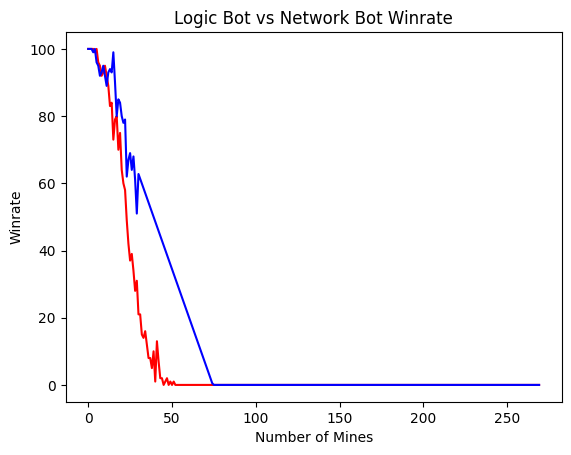

In [114]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(logic_bot_winrate,'r',label='Logic Bot')
plt.plot(network_bot_winrate,'b',label='Network Bot')
plt.title('Logic Bot vs Network Bot Winrate')
plt.xlabel('Number of Mines')
plt.ylabel('Winrate')
plt.show()

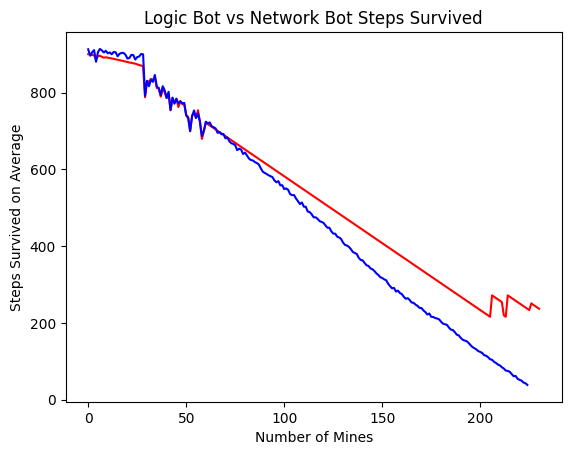

In [116]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(logic_bot_survival,'r',label='Logic Bot')
plt.plot(network_bot_survival,'b',label='Network Bot')
plt.title('Logic Bot vs Network Bot Steps Survived')
plt.xlabel('Number of Mines')
plt.ylabel('Steps Survived on Average')
plt.show()

As seen by the data the network bot is able to out perform the logic bot.

Task 3<br>
For this task data collection runs 100 trials on varying board sizes from 5 to 50 with 20% of the cells being mines. A new model is utilized to handle the varied board sizes and will be discussed below.

In [16]:
dataset_board = Dataset()

In [17]:
win = False
win_count = 0
count = 0
while count < 10:
    count+=1
    size_of_board = random.randint(5,50)
    num_of_mines = int(0.2*size_of_board)
    game = Game(size_of_board,size_of_board,num_of_mines)
    bot = LogicBot(game)
    win, steps = bot.play()
    if win:
        dataset_board.Add(steps[1:])
        win_count+=1
    else: dataset_board.Add(steps[1:-1])
print('Winrate = {:.2f}%'.format((win_count/count)*100))


Winrate = 100.00%


In [18]:
save_object(dataset_board,'dataset_board')

In [19]:
print(len(dataset_board.data))

11531


In [ ]:
dataset_board = load_object('dataset_board')

The model described below uses 3 convolutional layers using an increasing then decreasing architecture that uses padding to maintain the size of board in the output.

In [73]:
class CustomMinesweeperModel(nn.Module):
    def __init__(self):
        super(CustomMinesweeperModel, self).__init__()
        

        # Define input layer
        self.conv_layer1 = nn.Conv2d(11,30,3,1,1)
        self.batch_norm1 = nn.BatchNorm2d(30)
        self.conv_layer2 = nn.Conv2d(30,60,3,1,1)
        self.batch_norm2 = nn.BatchNorm2d(60)
        self.conv_layer3 = nn.Conv2d(60,30,3,1,1)
        self.batch_norm3 = nn.BatchNorm2d(30)
        self.output_layer = nn.Conv2d(30,1,3,1,1)

    def forward(self, input):
        output = nn.ReLU()(self.conv_layer1(input))
        output = self.batch_norm1(output)
        output = nn.ReLU()(self.conv_layer2(output))
        output = self.batch_norm2(output)
        output = nn.ReLU()(self.conv_layer3(output))
        output = self.batch_norm3(output)
        output = self.output_layer(output)
        return output.squeeze(1)


Training is the same as mentioned above, with the only change being the batch size, since the data is of boards of various sizes, only one board can be passed at a given epoch.

In [34]:
model = CustomMinesweeperModel()
model.train()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay = 0.0001)
batch_size = 1
validation_input, validation_output = get_batch(dataset_board,1)
validation_input = torch.Tensor(validation_input)
validation_output = torch.Tensor(validation_output)

for epoch in range(20):
    total_loss = 0
    total_validation_loss = 0
    for batch in range(len(dataset_board.data)//batch_size):
        input, output = get_batch(dataset_board,batch_size)
        input = torch.Tensor(input)
        output = torch.Tensor(output)
        logits = model(input)
        loss = loss_function(logits, output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss = loss.item()

        with torch.no_grad():
            validation_logits = model(validation_input)
            total_validation_loss += loss_function(validation_logits,validation_output).item()
    print('Average Training Loss over Batches = {:.4f}'.format(total_loss/ (len(dataset_board.data)//batch_size)))
    print('Average Validation Loss over Batches = {:.4f}'.format(total_validation_loss/ (len(dataset_board.data)//batch_size)))

Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.0653
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.0522
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.0671
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.0770
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.0751
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.0798
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.0593
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.0621
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.0594
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.0677
Average Training Loss over Batches = 0.0000
Average Validation Loss over Batches = 0.0683
Average Tr

In [35]:
torch.save(model.state_dict(),'minesweeper_board.pth')

In [ ]:
model = CustomMinesweeperModel()
model.load_state_dict(torch.load('minesweeper_board.pth'))

In [89]:
logic_bot_winrate = []
network_bot_winrate = []
logic_bot_survival = []
network_bot_survival = []

In [90]:
for i in range(5,51):
    num_of_mines = int(0.2*i*i)
    #print(num_of_mines)
    win = False
    win_count = 0
    steps_survived = 0
    for trial in range(100):
        game = Game(i,i,num_of_mines)
        bot = LogicBot(game)
        win, steps = bot.play()
        if win: win_count+=1
        steps_survived+=len(steps)
    logic_bot_winrate.append(win_count)
    logic_bot_survival.append(steps_survived/100)


In [ ]:
for i in range(5,51):
    steps_survived = 0
    wins = 0
    for trial in range(100):
        steps = 0
        opened = set()
        num_of_mines = int(0.2*i*i)
        game = Game(i,i,num_of_mines)
        move = game.Free()
        opened.add(move)
        game.Open(move)
        model.eval()

        board = torch.Tensor([game.GetGame()])
        move = model(board)[0]
        for cell in opened:
            x,y = cell
            move[x][y] = 0
        move = max_position(move)
        opened.add(move)
        game.Open(move)
        steps += 2
        playing = True
        while game.Open(move):
            board = torch.Tensor([game.GetGame()])
            move = model(board)[0]
            for cell in opened:
                x,y = cell
                move[x][y] = 0
            move = max_position(move)
            opened.add(move)
            playing = game.Open(move)
            steps+=1
        if steps == 9*9-10: wins+=1
        steps_survived+=steps
    network_bot_winrate(wins)
    network_bot_survival.append(steps_survived/100)
            

In [99]:
x_axis = [i for i in range(5,51)]

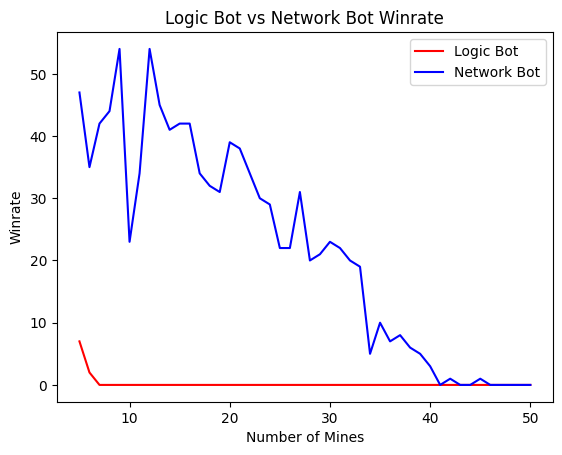

In [108]:
plt.figure()
plt.plot(x_axis,logic_bot_winrate,'r',label='Logic Bot')
plt.plot(x_axis,network_bot_winrate,'b',label='Network Bot')
plt.title('Logic Bot vs Network Bot Winrate')
plt.xlabel('Number of Mines')
plt.ylabel('Winrate')
plt.legend()
plt.show()

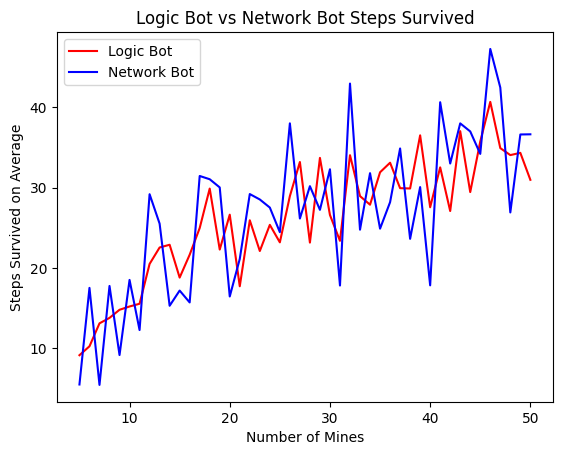

In [134]:
plt.figure()
plt.plot(x_axis,logic_bot_survival,'r',label='Logic Bot')
plt.plot(x_axis,network_bot_survival,'b',label='Network Bot')
plt.title('Logic Bot vs Network Bot Steps Survived')
plt.xlabel('Number of Mines')
plt.ylabel('Steps Survived on Average')
plt.legend()
plt.show()

As seen by the data the network bot is able to out perform the logic bot.